## This python notebook takes preprocessed 100m TEMP from the CESM2-LE and outputs netcdfs for each ensemble member so that we can run FEISTY with each one

In [1]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
from dask_jobqueue import PBSCluster
from glob import glob

### Get some DASK going to speed up processing

In [2]:
# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='25 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=2:mem=25GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ext', # Interface to use
)
# Scale up
cluster.scale(6)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kristenk/miniconda/envs/analysis6/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33811 instead
  f"Port {expected} is already in use.\n"


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/33811/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/33811/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.105:35313,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/33811/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Open up preprocessed POC_FLUX_bottom files
#### preprocessed using shell script extract_bottom_POC_FLUX.sh

In [4]:
mems = ['1001.001','1021.002','1041.003','1061.004','1081.005','1101.006','1121.007',
        '1141.008','1161.009','1181.010','1231.001','1231.002','1231.003','1231.004',
        '1231.005','1231.006','1231.007','1231.008','1231.009','1231.010','1251.001',
        '1251.002','1251.003','1251.004','1251.005','1251.006','1251.007','1251.008',
        '1251.009','1251.010','1281.001','1281.002','1281.003','1281.004','1281.005',
        '1281.006','1281.007','1281.008','1281.009','1281.010','1301.001','1301.002',
        '1301.003','1301.004','1301.005','1301.006','1301.007','1301.008','1301.009',
        '1301.010']

len(mems)

50

In [5]:
len(mems)

50

In [6]:
path='/glade/derecho/scratch/kristenk/CESM2-LE-processing/POC_flux_bottom'
v = 'POC_FLUX_IN'

In [7]:
ds_hist = xr.Dataset()

for mem in mems:
    print(mem)
    case = 'b.e21.BHISTcmip6.f09_g17.LE2-'+ mem
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.????01-????12.bottom.nc'))
    #files = files[0:10]
    dsm=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True)
    
    dsm['time'] = dsm.time_bound.compute().mean(dim="d2")
    ds_hist = xr.concat((ds_hist,dsm),dim='member_id')

1001.001
1021.002
1041.003
1061.004
1081.005
1101.006
1121.007
1141.008
1161.009
1181.010
1231.001
1231.002
1231.003
1231.004
1231.005
1231.006
1231.007
1231.008
1231.009
1231.010
1251.001
1251.002
1251.003
1251.004
1251.005
1251.006
1251.007
1251.008
1251.009
1251.010
1281.001
1281.002
1281.003
1281.004
1281.005
1281.006
1281.007
1281.008
1281.009
1281.010
1301.001
1301.002
1301.003
1301.004
1301.005
1301.006
1301.007
1301.008
1301.009
1301.010


In [8]:
keep_vars=['time_bound','TLAT','TLONG','time'] + ['pocToFloor']

ds_hist = ds_hist.drop([v for v in ds_hist.variables if v not in keep_vars])

In [9]:
ds_hist

,Array,Chunk
Bytes,45.32 GiB,56.25 MiB
Shape,"(50, 1980, 384, 320)","(1, 120, 384, 320)"
Count,25058 Tasks,850 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.51 MiB,1.88 kiB
Shape,"(50, 1980, 2)","(1, 120, 2)"
Count,25058 Tasks,850 Chunks
Type,object,numpy.ndarray


#### future scenario part

In [10]:
ds_ssp = xr.Dataset()

for mem in mems:
    print(mem)
    case = 'b.e21.BSSP370cmip6.f09_g17.LE2-'+ mem
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.????01-????12.bottom.nc'))
        
    dsm=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True)
    dsm['time'] = dsm.time_bound.compute().mean(dim="d2")
    ds_ssp = xr.concat((ds_ssp,dsm),dim='member_id')

1001.001
1021.002
1041.003
1061.004
1081.005
1101.006
1121.007
1141.008
1161.009
1181.010
1231.001
1231.002
1231.003
1231.004
1231.005
1231.006
1231.007
1231.008
1231.009
1231.010
1251.001
1251.002
1251.003
1251.004
1251.005
1251.006
1251.007
1251.008
1251.009
1251.010
1281.001
1281.002
1281.003
1281.004
1281.005
1281.006
1281.007
1281.008
1281.009
1281.010
1301.001
1301.002
1301.003
1301.004
1301.005
1301.006
1301.007
1301.008
1301.009
1301.010


In [11]:
keep_vars=['time_bound','TLAT','TLONG','time'] + ['pocToFloor']

ds_ssp = ds_ssp.drop([v for v in ds_ssp.variables if v not in keep_vars])

### merge the historical ds and SSP ds

In [12]:
ds = xr.concat((ds_hist,ds_ssp),dim='time')

In [13]:
ds['member_id'] = mems

### get coordinate data for the CESM ocean grid

In [14]:
import pop_tools

ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA

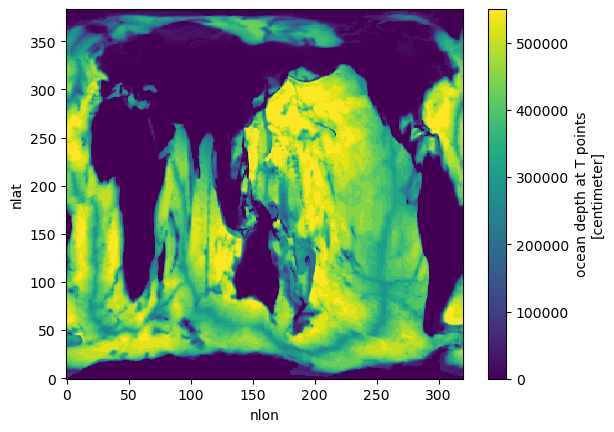

In [15]:
HT = xr.full_like(ds_grid.TAREA, fill_value=0.)
HT.attrs = dict(
    units='centimeter',
    long_name='ocean depth at T points',
    note='this field ignores overflows, which comprise isolated KMT pop-down points'
)
for j in range(len(ds_grid.nlat)):
    for i in range(len(ds_grid.nlon)):
        if ds_grid.KMT[j, i] > 0:
            k = int(ds_grid.KMT[j, i] - 1)
            HT.values[j, i] = ds_grid.z_w_bot[k]
            
HT.plot()

In [16]:
ds['time'][1978:1982]

<xarray.DataArray 'time' (time: 4)>
array([cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 1, 16, 13, 0, 0, 1, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2014-11-16 00:00:00 ... 2015-02-15 00:00:00

In [17]:
#ds_tmp = xr.open_dataset('/glade/derecho/scratch/kristenk/CESM2-LE-FEISTY_prep/mesozooC_zint_100m/CESM2-LE_HIST_SSP370_mesozooC_zint_100m_1001.001.nc')

In [18]:
#ds['time'] = ds_tmp.time

In [19]:
# '1001.001','1021.002','1041.003','1061.004','1081.005','1101.006','1121.007',
#         '1141.008','1161.009','1181.010','1231.001','1231.002','1231.003','1231.004',
#         '1231.005','1231.006','1231.007','1231.008','1231.009','1231.010','1251.001',
#         '1251.002','1251.003','1251.004','1251.005','1251.006','1251.007','1251.008',
#         '1251.009','1251.010','1281.001','1281.002','1281.003','1281.004','1281.005',
        # '1281.006','1281.007','1281.008','1281.009','1281.010','1301.001','1301.002',
        # '1301.003','1301.004','1301.005','1301.006','1301.007','1301.008','1301.009','1301.010'

mems = ['1001.001']

len(mems)

1

### Cycle through the enesmble members and write out each one individually

In [21]:
var='pocToFloor'

for mem in mems:

    print(mem)
    ds_out = ds[[var]]
    ds_out = ds_out.sel(member_id=mem).squeeze()
    ds_out = ds_out.drop(['member_id'])
    ds_out['HT'] = HT
    ds_out['KMT'] = ds_grid.KMT
    file_out = '/glade/derecho/scratch/kristenk/CESM2-LE-FEISTY_prep/POC_FLUX_bottom/CESM2-LE_HIST_SSP370_' + var + '_' + mem + '.nc'
    ds_out.to_netcdf(file_out, mode='w')
    

1001.001


In [22]:
ds

,Array,Chunk
Bytes,68.94 GiB,56.25 MiB
Shape,"(50, 3012, 384, 320)","(1, 120, 384, 320)"
Count,39882 Tasks,1300 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.30 MiB,1.88 kiB
Shape,"(50, 3012, 2)","(1, 120, 2)"
Count,39848 Tasks,1300 Chunks
Type,object,numpy.ndarray


In [23]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
